In [1]:
# import modules

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import year
import cartopy.crs as crs
import cartopy.feature as cfeature
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()



In [2]:
#  clean and load data
schema = StructType(
    [
        StructField("ride_id", StringType(), True),
        StructField("ridable_type", StringType(), True),
        StructField("started_at", TimestampType(), True),
        StructField("ended_at", TimestampType(), True),
        StructField("start_station_name", StringType(), True),
        StructField("start_station_id", StringType(), True),
        StructField("end_station_name", StringType(), True),
        StructField("end_station_id", StringType(), True),
        StructField("start_lat", DoubleType(), True),
        StructField("start_lng", DoubleType(), True),
        StructField("end_lat", DoubleType(), True),
        StructField("end_lng", DoubleType(), True),
        StructField("member_casual", StringType(), True),
        
    ]

) 

df = spark.read.format('csv').option("header", True).schema(schema).load("data")
df = df.na.drop()
df.createOrReplaceTempView("table")

In [3]:
#  clean data
df = df.distinct()



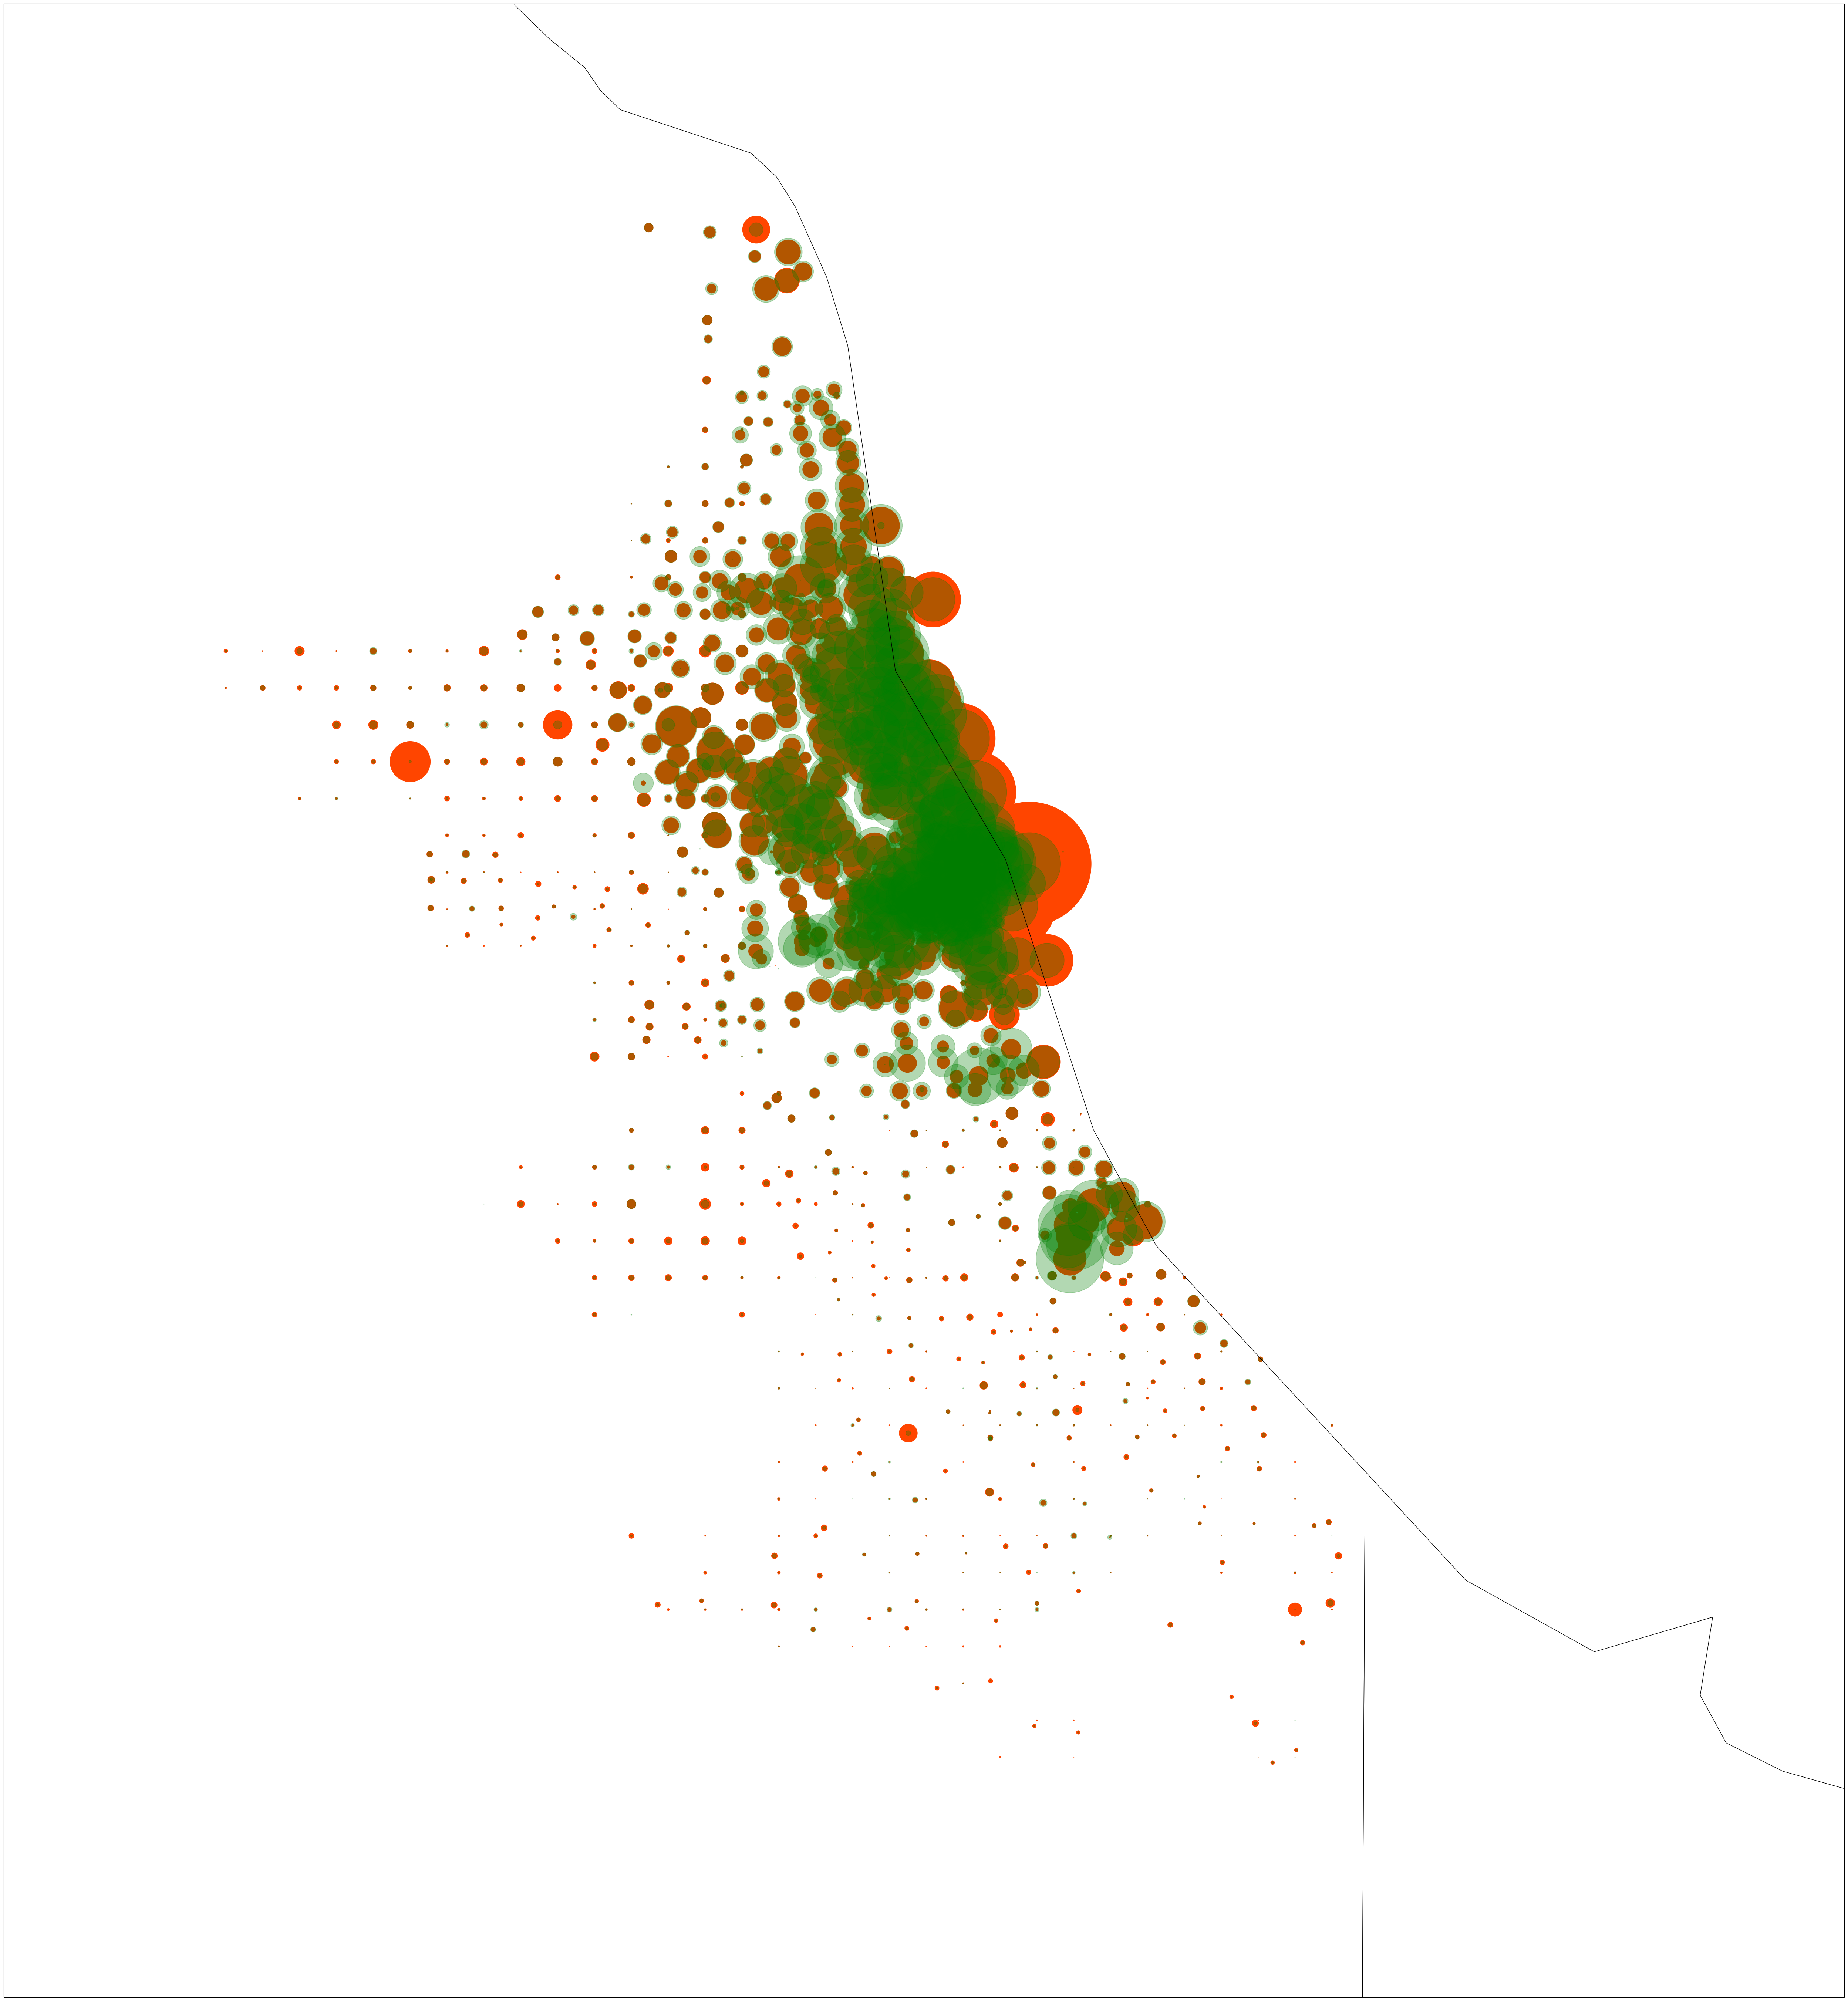

In [434]:
# distribution map
y_lim_left = 41.5848241
y_lim_right = 42.1255887
x_lim_left = -87.8902517
x_lim_right = -87.3909821
fig_size = (70,70)
members_alpha = 0.3
casual_alpha = 1
members_colour = 'green'
casual_colour = "orangered"

grouped_casual = spark.sql("""
        SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
        FROM (
    
            SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
            FROM table 
            WHERE member_casual = 'casual' 

        )
            
          GROUP BY start_lat_sub, start_lng_sub
        """
)


grouped_member = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table 
        WHERE member_casual = 'member' 
   
    )
                      
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
)

fig = plt.figure(figsize= fig_size)

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.stock_img()
ax.coastlines()

ax.add_feature(cfeature.STATES)

# ax.set_extent([-90, -90, 35, 45],
#               crs=crs.PlateCarree()) ## Important

ax.set_ylim(y_lim_left, y_lim_right)
ax.set_xlim(x_lim_left, x_lim_right)



lat_casual = [float(i[0]) for i in grouped_casual.select("start_lat_sub").collect()]
lng_casual = [float(i[0]) for i in grouped_casual.select("start_lng_sub").collect()]
count_casual = [i[0] for i in grouped_casual.select("count").collect()]

lat_member = [float(i[0]) for i in grouped_member.select("start_lat_sub").collect()]
lng_member = [float(i[0]) for i in grouped_member.select("start_lng_sub").collect()]
count_member = [i[0] for i in grouped_member.select("count").collect()]

# print(lat[0], lng[0], count[0])

# print(lat[:10])

plt.scatter(x=lng_casual, y=lat_casual,
            color= casual_colour,
            s=count_casual,
            alpha=casual_alpha,
            transform=crs.PlateCarree()) ## Important

plt.scatter(x=lng_member, y=lat_member,
            color=members_colour,
            s=count_member,
            alpha=members_alpha,
            transform=crs.PlateCarree()) ## Important

plt.show()

[2611171]
[1758189]


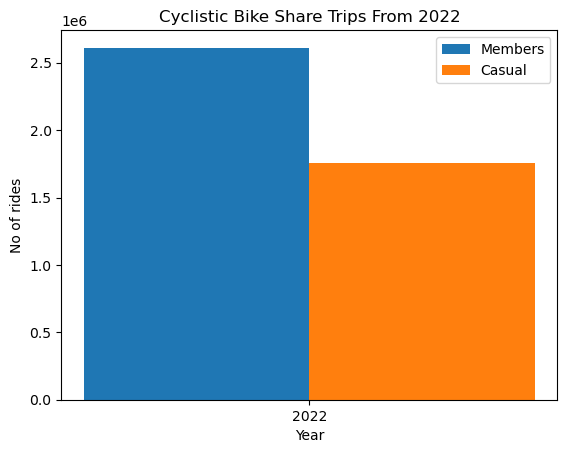

In [383]:


count_members = spark.sql("""
                              SELECT count(member_casual) as count FROM table 
                              WHERE member_casual = 'member'
                              
                              """)

count_casual = spark.sql("""
                              SELECT count(member_casual) as count FROM table 
                              WHERE member_casual = 'casual'
                              
                              """)


#  create a list of the data
members = [i[0] for i in count_members.select("count").collect()] 


casual = [i[0] for i in count_casual.select("count").collect()]

print(members)
print(casual)

X = ["2022"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("No of rides")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2022')

plt.legend()
plt.show()

In [384]:
# mean ride length in minutes
average_ride_length = spark.sql("""
    SELECT member_casual, AVG(ride_length) as average_ride_length, max(ride_length) as max
        FROM (
            SELECT 
                member_casual
                ,DATEDIFF(minute, started_at ,ended_at) as ride_length
                , ride_id
                , started_at
                , ended_at
            FROM table
        
        )
        GROUP BY member_casual
        """
        )

average_ride_length.show()


+-------------+-------------------+-----+
|member_casual|average_ride_length|  max|
+-------------+-------------------+-----+
|       casual|  23.50199665678718|34354|
|       member| 11.961798365560892| 1493|
+-------------+-------------------+-----+



In [385]:
ride_length = spark.sql("""
        SELECT 
            member_casual
            , DATEDIFF(minute, started_at ,ended_at) as ride_length
            , start_station_id
        FROM table
        
        """
        
        )

ride_length.show()

+-------------+-----------+----------------+
|member_casual|ride_length|start_station_id|
+-------------+-----------+----------------+
|       casual|         23|           13084|
|       casual|          0|           13084|
|       casual|         25|           20222|
|       casual|          9|             637|
|       casual|         34|           13256|
|       casual|          0|           13084|
|       casual|          8|           13256|
|       casual|         70|    TA1306000002|
|       casual|        112|           20222|
|       casual|        112|           20222|
|       casual|         59|           13084|
|       casual|         18|           13084|
|       casual|          0|    TA1306000002|
|       casual|         15|           13084|
|       casual|          1|             637|
|       casual|          4|           13084|
|       casual|         31|           13084|
|       casual|         11|           20222|
|       casual|          1|           20222|
|       ca

+-------------+-------+------+
|member_casual|weekday| count|
+-------------+-------+------+
|       member|      1|297733|
|       member|      2|375171|
|       member|      3|411249|
|       member|      4|412795|
|       member|      5|415890|
|       member|      6|360054|
|       member|      7|338279|
+-------------+-------+------+

+-------------+-------+------+
|member_casual|weekday| count|
+-------------+-------+------+
|       casual|      1|301316|
|       casual|      2|210759|
|       casual|      3|196390|
|       casual|      4|203576|
|       casual|      5|230007|
|       casual|      6|248797|
|       casual|      7|367344|
+-------------+-------+------+

[297733, 375171, 411249, 412795, 415890, 360054, 338279]
[301316, 210759, 196390, 203576, 230007, 248797, 367344]


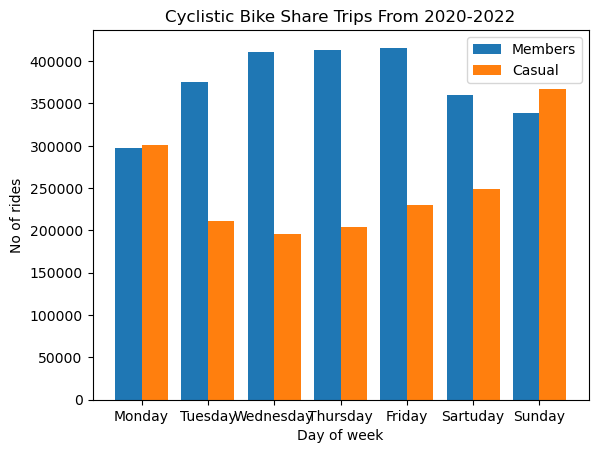

In [386]:
member_week_day = spark.sql("""
        SELECT member_casual
        , dayofweek(started_at) as weekday
        , count(dayofweek(started_at)) as count
        FROM table
        WHERE member_casual == "member"
        GROUP BY weekday, member_casual
        ORDER BY weekday 
        """
        )

casual_week_day = spark.sql("""
        SELECT member_casual, dayofweek(started_at) as weekday, count(dayofweek(started_at)) as count
        FROM table
        WHERE member_casual == "casual"
        GROUP BY weekday, member_casual
        ORDER BY weekday 
        """
        )

member_week_day.show()
casual_week_day.show()

#  create a list of the data
members = [i[0] for i in member_week_day.select("count").collect()] 
casual = [i[0] for i in casual_week_day.select("count").collect()] 

print(members)
print(casual)

X = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sartuday", "Sunday"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Day of week")
plt.ylabel("No of rides")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()

+---------------+---------+-------+------------------------------------+
|dayofweek_total|dayofweek|  total|member_avarage_rides_per_day_of_week|
+---------------+---------+-------+------------------------------------+
|         297733|        1|4369360|                  6.8141100756174815|
|         375171|        2|4369360|                    8.58640624713917|
|         411249|        3|4369360|                   9.412110698134281|
|         412795|        4|4369360|                   9.447493454418954|
|         415890|        5|4369360|                   9.518327626929345|
|         360054|        6|4369360|                   8.240428804218466|
|         338279|        7|4369360|                   7.742072065474121|
+---------------+---------+-------+------------------------------------+

+---------------+---------+-------+------------------------------------+
|dayofweek_total|dayofweek|  total|casual_avarage_rides_per_day_of_week|
+---------------+---------+-------+---------------

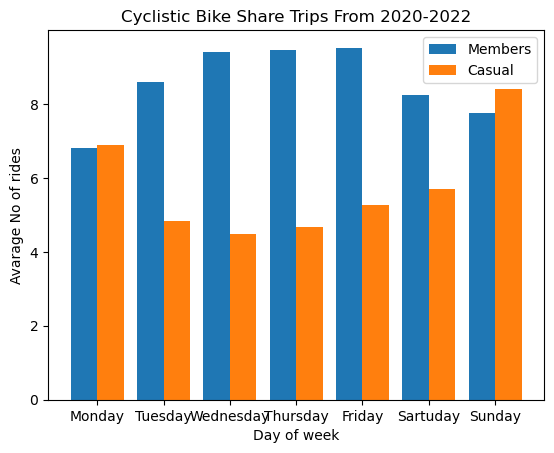

In [371]:
member_day_of_week_average = spark.sql("""
        SELECT 
        DISTINCT
         ss.dayofweek_total
         , ss.dayofweek
         , s.total
         , (ss.dayofweek_total/s.total) * 100 as member_avarage_rides_per_day_of_week
         FROM table t
     
        cross join (
            SELECT
                dayofweek(started_at) as dayofweek
                ,count(dayofweek(started_at)) as dayofweek_total
            FROM table t
            WHERE t.member_casual = "member"
            group by dayofweek
            
        ) ss
        
        CROSS JOIN (
            SELECT
            count(*) as total
            FROM table t
            LIMIT 1
            
        ) s
        order by dayofweek
        """
        )

casual_day_of_week_average = spark.sql("""
        SELECT 
        DISTINCT
         ss.dayofweek_total
         , ss.dayofweek
         , s.total
         , (ss.dayofweek_total/s.total) * 100 as casual_avarage_rides_per_day_of_week
         FROM table t
     
        cross join (
            SELECT
                dayofweek(started_at) as dayofweek
                ,count(dayofweek(started_at)) as dayofweek_total
            FROM table t
            WHERE t.member_casual = "casual"
            group by dayofweek
            
        ) ss
        
        CROSS JOIN (
            SELECT
            count(*) as total
            FROM table t
            LIMIT 1
            
        ) s
        order by dayofweek
        """
        )




member_day_of_week_average.show()
casual_day_of_week_average.show()

#  create a list of the data
members = [i[0] for i in member_day_of_week_average.select("member_avarage_rides_per_day_of_week").collect()] 
casual = [i[0] for i in casual_day_of_week_average.select("casual_avarage_rides_per_day_of_week").collect()] 

print(members)
print(casual)

X = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sartuday", "Sunday"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Day of week")
plt.ylabel("Avarage No of rides")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()

+-------------+-----+------+
|member_casual|month| count|
+-------------+-----+------+
|       member|    1| 67523|
|       member|    2| 74034|
|       member|    3|148827|
|       member|    4|180663|
|       member|    5|282299|
|       member|    6|328282|
|       member|    7|331002|
|       member|    8|335230|
|       member|    9|314230|
|       member|   10|262945|
|       member|   11|182238|
|       member|   12|103898|
+-------------+-----+------+

+-------------+-----+------+
|member_casual|month| count|
+-------------+-----+------+
|       casual|    1| 12605|
|       casual|    2| 15144|
|       casual|    3| 67156|
|       casual|    4| 91897|
|       casual|    5|220246|
|       casual|    6|292068|
|       casual|    7|311678|
|       casual|    8|270095|
|       casual|    9|220915|
|       casual|   10|151324|
|       casual|   11| 73556|
|       casual|   12| 31505|
+-------------+-----+------+

[67523, 74034, 148827, 180663, 282299, 328282, 331002, 335230, 314230,

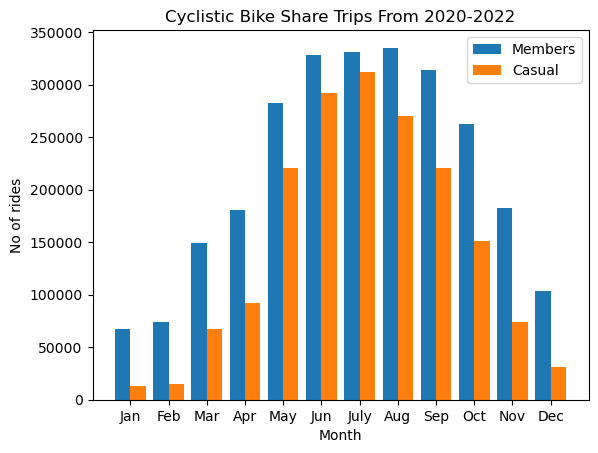

In [347]:
member_month = spark.sql("""
        SELECT member_casual
        , month(started_at) as month
        , count(month(started_at)) as count
        FROM table
        WHERE member_casual == "member"
        GROUP BY month, member_casual
        ORDER BY month 
        """
        )

casual_month = spark.sql("""
        SELECT member_casual, month(started_at) as month, count(month(started_at)) as count
        FROM table
        WHERE member_casual == "casual"
        GROUP BY month, member_casual
        ORDER BY month 
        """
        )

member_month.show()
casual_month.show()

#  create a list of the data
members = [i[0] for i in member_month.select("count").collect()] 
casual = [i[0] for i in casual_month.select("count").collect()] 

print(members)
print(casual)

X = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Month")
plt.ylabel("No of rides")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()

+-----------+-----+-------+------------------------------+
|month_total|month|  total|member_avarage_rides_per_month|
+-----------+-----+-------+------------------------------+
|      67523|    1|4369360|            1.5453750663712764|
|      74034|    2|4369360|            1.6943900250837651|
|     148827|    3|4369360|             3.406151015251661|
|     180663|    4|4369360|             4.134770309610561|
|     282299|    5|4369360|            6.4608775655931305|
|     328282|    6|4369360|             7.513274255268507|
|     331002|    7|4369360|             7.575525935148397|
|     335230|    8|4369360|             7.672290678726404|
|     314230|    9|4369360|            7.1916710914184225|
|     262945|   10|4369360|            6.0179293992712894|
|     182238|   11|4369360|              4.17081677865866|
|     103898|   12|4369360|            2.3778768515297437|
+-----------+-----+-------+------------------------------+

+-----------+-----+-------+----------------------------

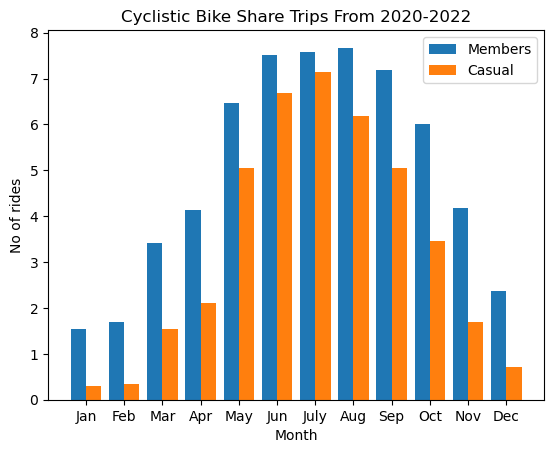

In [361]:



member_month = spark.sql("""
        SELECT 
        DISTINCT
         ss.month_total
         , ss.month
         , s.total
         , (ss.month_total/s.total) * 100 as member_avarage_rides_per_month
         FROM table t
     
        cross join (
            SELECT
                month(started_at) as month
                ,count(month(started_at)) as month_total
            FROM table t
            WHERE t.member_casual = "member"
            group by month
            
        ) ss
        
        CROSS JOIN (
            SELECT
            count(month(started_at)) as total
            FROM table t
            LIMIT 1
            
        ) s
        order by month
        """
        )


casual_month = spark.sql("""
    SELECT 
        DISTINCT
         ss.month_total as month_total
         , ss.month
         , s.total as total
         , (month_total/total) * 100 as casual_avarage_rides_per_month
         FROM table t
     
        cross join (
            SELECT
                month(started_at) as month
                ,count(month(started_at)) as month_total
            FROM table t
            WHERE t.member_casual = "casual"
            group by month
            
        ) ss
        
        CROSS JOIN (
            SELECT
            count(month(started_at)) as total
            FROM table t
            LIMIT 1
            
        ) s
        order by month
        """
        )

member_month.show()
casual_month.show()

#  create a list of the data
members = [i[0] for i in member_month.select("member_avarage_rides_per_month").collect()] 
casual = [i[0] for i in casual_month.select("casual_avarage_rides_per_month").collect()] 

print(members)
print(casual)

X = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Month")
plt.ylabel("No of rides")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()

+-------------+-------+------------------+
|member_casual|weekday|   avg_ride_length|
+-------------+-------+------------------+
|       member|      1| 13.35978208663467|
|       member|      2|11.543210962467782|
|       member|      3|11.301211674678845|
|       member|      4|11.357186981431461|
|       member|      5|11.541340258241362|
|       member|      6|11.737556033261678|
|       member|      7|13.492090848086935|
+-------------+-------+------------------+

+-------------+-------+------------------+
|member_casual|weekday|   avg_ride_length|
+-------------+-------+------------------+
|       casual|      1| 26.73366830835402|
|       casual|      2|  24.3433162996598|
|       casual|      3|20.950725597026324|
|       casual|      4|20.228224348646204|
|       casual|      5|20.912646136856704|
|       casual|      6| 21.86632475471971|
|       casual|      7|26.275839540049652|
+-------------+-------+------------------+

[13.35978208663467, 11.543210962467782, 11.301211674

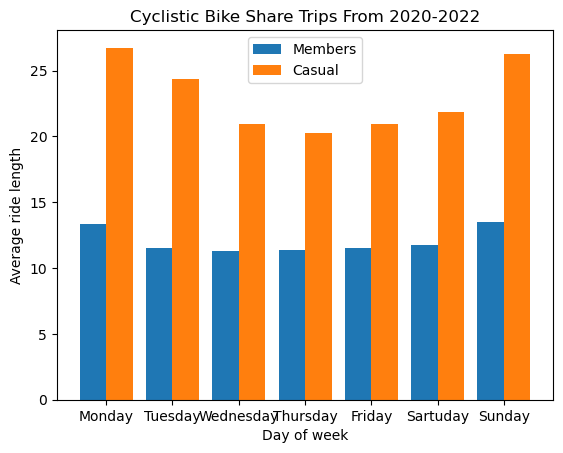

In [349]:
member_ride_length_week_day = spark.sql(
        """  
        SELECT 
        member_casual
        , weekday
        , avg(ride_length ) as avg_ride_length
        FROM (
            SELECT 
                member_casual
                ,DATEDIFF(minute, started_at ,ended_at) as ride_length
                , dayofweek(started_at) as weekday
                , ride_id
                , started_at
                , ended_at
            FROM table
        
        )
        WHERE member_casual = "member"
        GROUP BY member_casual, weekday
        order by weekday asc
        """
)  

casual_ride_length_week_day = spark.sql(
        """  
        SELECT 
        member_casual
        , weekday
        , avg(ride_length ) as avg_ride_length
        FROM (
            SELECT 
                member_casual
                ,DATEDIFF(minute, started_at ,ended_at) as ride_length
                , dayofweek(started_at) as weekday
                , ride_id
                , started_at
                , ended_at
            FROM table
        
        )
        WHERE member_casual = "casual"
        GROUP BY member_casual, weekday
        order by weekday asc
        """
) 

member_ride_length_week_day.show()
casual_ride_length_week_day.show()

#  create a list of the data
members = [i[0] for i in member_ride_length_week_day.select("avg_ride_length").collect()] 
casual = [i[0] for i in casual_ride_length_week_day.select("avg_ride_length").collect()] 

print(members)
print(casual)

X = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sartuday", "Sunday"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Day of week")
plt.ylabel("Average ride length")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()

+-------------+-----+------------------+
|member_casual|month|   avg_ride_length|
+-------------+-----+------------------+
|       member|    1| 9.778564341039349|
|       member|    2|10.155914849933815|
|       member|    3| 11.30574425339488|
|       member|    4|11.119526411052624|
|       member|    5|12.811600466172392|
|       member|    6| 13.19354396524939|
|       member|    7|13.013646443223909|
|       member|    8|12.616525967246368|
|       member|    9|12.132909015689146|
|       member|   10|11.184639373252962|
|       member|   11| 10.33386011698987|
|       member|   12| 9.712179252728637|
+-------------+-----+------------------+

+-------------+-----+------------------+
|member_casual|month|   avg_ride_length|
+-------------+-----+------------------+
|       casual|    1|26.864656882189607|
|       casual|    2|24.331022187004756|
|       casual|    3|27.946735958067784|
|       casual|    4|25.456881073375627|
|       casual|    5|27.214877909246933|
|       casual|

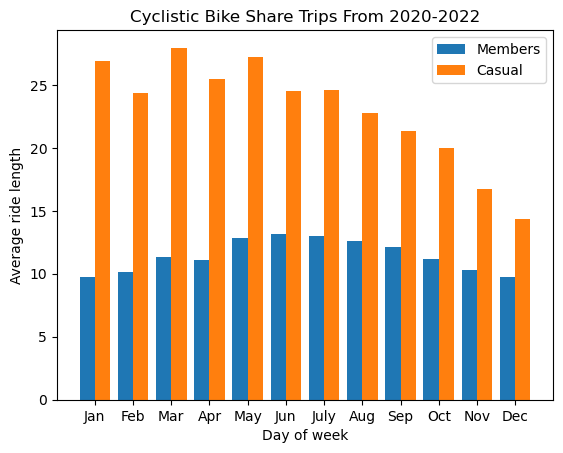

In [350]:
member_ride_length_month = spark.sql(
        """  
        SELECT 
        member_casual
        , month
        , avg(ride_length ) as avg_ride_length
        FROM (
            SELECT 
                member_casual
                ,DATEDIFF(minute, started_at ,ended_at) as ride_length
                , month(started_at) as month
                , ride_id
                , started_at
                , ended_at
            FROM table
        
        )
        WHERE member_casual = "member"
        GROUP BY member_casual, month
        order by month asc
        """
)  

casual_ride_length_month = spark.sql(
        """  
        SELECT 
        member_casual
        , month
        , avg(ride_length ) as avg_ride_length
        FROM (
            SELECT 
                member_casual
                ,DATEDIFF(minute, started_at ,ended_at) as ride_length
                , month(started_at) as month
                , ride_id
                , started_at
                , ended_at
            FROM table
        
        )
        WHERE member_casual = "casual"
        GROUP BY member_casual, month
        order by month asc
        """
) 

member_ride_length_month.show()
casual_ride_length_month.show()

#  create a list of the data
members = [i[0] for i in member_ride_length_month.select("avg_ride_length").collect()] 
casual = [i[0] for i in casual_ride_length_month.select("avg_ride_length").collect()] 

print(members)
print(casual)

X = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Day of week")
plt.ylabel("Average ride length")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()